### Import Required Libraries
First, we import all necessary libraries for data manipulation, analysis, and visualization.

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Set display options for better output formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Load the Dataset
Load the raw Audible dataset to begin our cleaning process.

In [ ]:
# Load the dataset from the specified path
data = pd.read_csv('audible_uncleaned.csv')

# Display basic information about the dataset
print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

# Display the first few rows to understand the structure
print("\nFirst 5 rows of the dataset:")
data.head()

### 2.1 Identify Missing Values
Before cleaning, we need to understand what data quality issues exist in our dataset.

In [ ]:
# Identify missing values in the dataset
missing_values = data.isnull().sum()

# Display missing values count per column
print("Missing Values per Column:")
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")
print(f"Percentage of missing data: {(missing_values.sum() / (data.shape[0] * data.shape[1])) * 100:.2f}%")

### 2.2 Detect Duplicate Rows
Duplicate entries can skew our analysis, so we need to identify and handle them.

In [ ]:
# Detect duplicate rows
duplicates = data.duplicated().sum()

# Display the number of duplicate rows
print(f"Number of duplicate rows: {duplicates}")
print(f"Percentage of duplicates: {(duplicates / len(data)) * 100:.2f}%")

if duplicates > 0:
    print("\nSample duplicate rows:")
    print(data[data.duplicated(keep=False)].head())

### 2.3 Check Data Types
Examining data types helps us identify columns that need type conversion or formatting issues.

In [ ]:
# Check data types of all columns to spot any inconsistent data formats
print("Data Types per Column:")
print(data.dtypes)
print("\nSample data from each column:")
for col in data.columns:
    print(f"\n{col}: {data[col].dropna().iloc[0] if not data[col].dropna().empty else 'No data'}")

### 3.1 Remove Duplicate Rows
Remove all duplicate rows while keeping the first occurrence.

In [ ]:
# Store initial count for comparison
initial_rows = len(data)

# Remove duplicate rows
data.drop_duplicates(inplace=True)

# Calculate rows removed
rows_removed = initial_rows - len(data)

print(f"Number of duplicate rows removed: {rows_removed}")
print(f"Dataset shape after removing duplicates: {data.shape}")
print("\nDataset after removing duplicates:")
data.head()

### 3.2 Standardize Language Column
Capitalize the first letter of each word in the 'language' column.

In [ ]:
# Capitalize the first letter of each word in the 'language' column
data['language'] = data['language'].str.capitalize()

# Display the updated 'language' column
print("Updated 'language' column:")
print(data['language'].value_counts())

### 3.3 Clean Author and Narrator Names
Create a function to standardize name formatting.

In [ ]:
# Insert a space between the first and last name and after the comma
def format_names(name):
    """
    Clean and format names by:
    1. Adding space after commas
    2. Adding space between CamelCase words (FirstnameLastname -> Firstname Lastname)
    """
    if pd.isna(name):
        return name
    
    # Add a space after the comma
    name = name.replace(",", ", ")
    
    # Insert space between first and last name by capitalizing where the uppercase starts
    # Using regex to insert space before each uppercase letter that follows a lowercase letter
    name = re.sub(r'([a-z])([A-Z])', r'\1 \2', name)
    
    return name

# Apply the function to the 'author' column
print("Original author format:", data['author'].iloc[0])
data['author'] = data['author'].apply(format_names)
print("Formatted author:", data['author'].iloc[0])

print("\nUpdated 'author' column with formatted names:")
print(data[['author']].head())

In [ ]:
# Apply the same function to the 'narrator' column
print("Original narrator format:", data['narrator'].iloc[0])
data['narrator'] = data['narrator'].apply(format_names)
print("Formatted narrator:", data['narrator'].iloc[0])

print("\nUpdated 'narrator' column with formatted names:")
print(data[['narrator']].head())

### 3.4 Remove Prefixes from Author and Narrator Columns
Strip prefixes and clean up extra whitespace.

In [ ]:
# Remove 'Writtenby:' from the 'author' column
data['author'] = data['author'].str.replace('Writtenby:', '', regex=False)

# Remove 'Narratedby:' from the 'narrator' column  
data['narrator'] = data['narrator'].str.replace('Narratedby:', '', regex=False)

# Clean up any extra spaces
data['author'] = data['author'].str.strip()
data['narrator'] = data['narrator'].str.strip()

# Display the cleaned 'author' and 'narrator' columns
print("Cleaned 'author' and 'narrator' columns:")
print(data[['author', 'narrator']].head())

### 3.5 Convert Time Format to Minutes
Convert all time values to total minutes for consistent numerical analysis.

In [ ]:
def convert_time_to_minutes(time_str):
    """
    Convert time format from "X hrs and Y mins" to total minutes.
    Handles various formats:
    - "2 hrs and 20 mins" -> 140 minutes
    - "1 hr and 30 mins" -> 90 minutes
    - "45 mins" -> 45 minutes
    """
    if pd.isna(time_str):
        return 0
    
    # Use regex to extract hours and minutes
    hours = 0
    minutes = 0
    time_parts = time_str.split(' and ')
    
    for part in time_parts:
        if 'hr' in part:
            hours_match = re.search(r'(\d+)', part)
            if hours_match:
                hours = int(hours_match.group())
        elif 'min' in part:
            minutes_match = re.search(r'(\d+)', part)
            if minutes_match:
                minutes = int(minutes_match.group())
    
    # Calculate total minutes
    total_minutes = (hours * 60) + minutes
    return total_minutes

# Show before and after conversion
print("Before conversion:")
print(data['time'].head())

# Apply the function to replace 'time' column with total minutes
data['time'] = data['time'].apply(convert_time_to_minutes)

print("\nAfter conversion to minutes:")
print(data['time'].head())

# Check the data types and the updated 'time' column
print(f"\nTime column statistics:")
print(f"Average duration: {data['time'].mean():.1f} minutes ({data['time'].mean()/60:.1f} hours)")
print(f"Range: {data['time'].min()} - {data['time'].max()} minutes")

### 3.6 Convert Release Date to Proper DateTime Format
Convert the releasedate column from string to datetime format.

In [ ]:
# Show original format
print("Original release date format:")
print(data['releasedate'].head())

# Convert 'releasedate' to datetime format
data['releasedate'] = pd.to_datetime(data['releasedate'], errors='coerce')

print("\nAfter datetime conversion:")
print(data['releasedate'].head())
print(f"\nData type: {data['releasedate'].dtype}")

# Check for any conversion errors
conversion_errors = data['releasedate'].isna().sum()
print(f"Conversion errors (NaT values): {conversion_errors}")

### 4.1 Extract Star Ratings and Number of Ratings
Use regex to extract star rating and number of ratings into separate columns.

In [ ]:
# Step 1: Rename the original 'stars' column to preserve the source text
data.rename(columns={'stars': 'stars_original_text'}, inplace=True, errors='ignore')

# Step 2: Ensure the source text column is a string type
data['stars_original_text'] = data['stars_original_text'].astype(str)

print("Original stars format:")
print(data['stars_original_text'].head())

# Step 3: Define the regular expression pattern for the format "X out of 5 starsY ratings"
pattern = r'(?P<star_rating>\d\.?\d*)\s*out of 5 stars(?P<num_ratings>\d+)\s*ratings'

# Step 4: Use .str.extract() to pull the data into new columns based on the pattern
extracted_data = data['stars_original_text'].str.extract(pattern)

# Step 5: Create the new columns and convert them to numeric types
data['star_rating'] = pd.to_numeric(extracted_data['star_rating'], errors='coerce')
data['num_ratings'] = pd.to_numeric(extracted_data['num_ratings'], errors='coerce')

# Step 6: Replace any resulting empty (NaN) values in the new columns with 0
data.fillna({'star_rating': 0, 'num_ratings': 0}, inplace=True)

# Step 7: Convert 'num_ratings' to a whole number (integer)
data['num_ratings'] = data['num_ratings'].astype(int)

print("\nData Transformation Result:")
print(data[['stars_original_text', 'star_rating', 'num_ratings']].head())

### 4.2 Finalize Star Rating Columns
Round star ratings and rename columns for clarity.

In [ ]:
# Round the star_rating column to one decimal place
data['star_rating'] = data['star_rating'].round(1)

# Rename the final columns for clarity
data.rename(columns={'star_rating': 'stars', 'num_ratings': 'ratings'}, inplace=True)

# Display the result
print("Final stars and ratings columns:")
print(data[['stars', 'ratings']].head())

# Show statistics
print(f"\nStar ratings statistics:")
print(f"Average rating: {data['stars'].mean():.2f}")
print(f"Rating distribution:")
print(data['stars'].value_counts().sort_index())

### 5.1 Clean and Standardize Price Data
Remove non-numeric characters and convert to proper numeric format.

In [ ]:
print("Original price format:")
print(data['price'].head())

# Remove any non-numeric characters (e.g., commas, dollar signs)
data['price'] = data['price'].astype(str).str.replace(r'[^\d.]', '', regex=True)

# Convert the price column to numeric
data['price'] = pd.to_numeric(data['price'], errors='coerce')

# Handle any NaN values that might result from conversion
data['price'] = data['price'].fillna(0)

# Round the 'price' column to 2 decimal places
data['price'] = data['price'].round(2)

print("\nCleaned price column:")
print(data['price'].head())

# Show price statistics
print(f"\nPrice statistics:")
print(f"Average price: ${data['price'].mean():.2f}")
print(f"Price range: ${data['price'].min():.2f} - ${data['price'].max():.2f}")
print(f"Median price: ${data['price'].median():.2f}")

### 6.1 Remove Unnecessary Columns and Rename for Clarity
Drop the original text column and rename columns for better readability.*

In [ ]:
# Drop the 'stars_original_text' column as it's no longer needed
data = data.drop(columns=['stars_original_text'])

# Rename columns for better clarity and consistency
data.rename(columns={
    'time': 'time_minutes', 
    'releasedate': 'release_date'
}, inplace=True)

print("Final dataset structure:")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

# Display the final cleaned dataset
print("\nFinal cleaned dataset:")
data.head()

### 7.1 Final Data Quality Check
Perform comprehensive quality checks on the cleaned dataset.

In [ ]:
print("=== FINAL DATA QUALITY REPORT ===")
print(f"Dataset shape: {data.shape}")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n1. Missing Values:")
missing_final = data.isnull().sum()
print(missing_final[missing_final > 0] if missing_final.sum() > 0 else "No missing values!")

print("\n2. Duplicate Rows:")
duplicates_final = data.duplicated().sum()
print(f"No duplicates!" if duplicates_final == 0 else f"{duplicates_final} duplicates found")

print("\n3. Data Types:")
print(data.dtypes)

print("\n4. Data Summary Statistics:")
print(data.describe(include='all'))

### 7.2 Save Cleaned Dataset
**Why:** Preserve our cleaned data for future analysis and sharing.
**Action:** Export the cleaned dataset to a new CSV file.

In [ ]:
# Save the cleaned dataset
output_filename = 'audible_cleaned_final.csv'
data.to_csv(output_filename, index=False)

print(f"Cleaned dataset saved as '{output_filename}'")
print(f"Final dataset: {data.shape[0]:,} rows × {data.shape[1]} columns")

# Create a summary of cleaning operations performed
cleaning_summary = {
    'Operation': [
        'Removed duplicate rows',
        'Standardized language capitalization', 
        'Formatted author/narrator names',
        'Removed text prefixes',
        'Converted time to minutes',
        'Converted dates to datetime',
        'Extracted star ratings',
        'Cleaned price format',
        'Renamed columns for clarity'
    ],
    'Impact': [
        f'{rows_removed} rows removed',
        'Consistent capitalization',
        'Proper name spacing',
        'Clean text fields',
        'Numerical time analysis ready',
        'Date analysis ready', 
        'Separate rating metrics',
        'Numerical price analysis ready',
        'Improved readability'
    ]
}

cleaning_df = pd.DataFrame(cleaning_summary)
print("\n=== CLEANING OPERATIONS SUMMARY ===")
print(cleaning_df.to_string(index=False))

### 8.1 Language Distribution Analysis
Create a pie chart showing the distribution of audiobooks by language, grouping smaller languages into "Other Languages" for clarity.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Count number of audiobooks per language
language_counts = data['language'].value_counts()

# Compute total count for percentage calculation
total = language_counts.sum()

print("Language distribution (raw counts):")
print(language_counts)

# Separate languages with ≥1% and group others
threshold = 0.01  # 1%
main_languages = language_counts[language_counts / total >= threshold]
other_languages = language_counts[language_counts / total < threshold]

print(f"\nLanguages representing ≥1% of data: {len(main_languages)}")
print(f"Languages grouped as 'Other': {len(other_languages)}")

# Add "Other Languages" as a merged entry
language_counts_cleaned = main_languages.copy()
if len(other_languages) > 0:
    language_counts_cleaned['Other Languages'] = other_languages.sum()

# Plot updated pie chart
plt.figure(figsize=(8, 8))
plt.pie(language_counts_cleaned, 
        labels=language_counts_cleaned.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=plt.cm.Set3.colors)
plt.title('Distribution of Audiobooks by Language', fontsize=16, fontweight='bold')
plt.axis('equal')  # Ensures the pie is circular
plt.tight_layout()
plt.show()

print(f"\nInsight: The dataset contains audiobooks in {len(language_counts)} different languages")
print(f"Market Focus: {language_counts.index[0]} dominates with {(language_counts.iloc[0]/total)*100:.1f}% of all audiobooks")

### 8.2 Top Authors by Average Rating Analysis
Analyze and visualize the top 10 authors based on their average ratings.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute and sort average rating per author
# Note: Using 'ratings' column (number of ratings) - if you meant 'stars' (star rating), change accordingly
author_ratings = data.groupby('author')['stars'].mean().sort_values(ascending=False).head(10).round(2)
author_df = author_ratings.reset_index()  # Convert to DataFrame for plotting

print("Top 10 Authors by Average Star Rating:")
print(author_df)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=author_df,
    x='stars',
    y='author',
    hue='author',             # Assign hue to match palette with y-values
    palette='viridis',
    legend=False              # Hide legend since it's redundant
)

# Add text labels to bars
for index, value in enumerate(author_df['stars']):
    plt.text(value + 0.01, index, str(value), va='center', fontweight='bold')

plt.title('Top 10 Authors by Average Star Rating', fontsize=16, fontweight='bold')
plt.xlabel('Average Star Rating', fontsize=12)
plt.ylabel('Author', fontsize=12)
plt.xlim(0, 5.5)  # Set appropriate scale for star ratings
plt.tight_layout()
plt.show()

# Additional analysis: Authors with most ratings
print("\n" + "="*50)
print("Authors with Most Total Ratings:")
top_rated_authors = data.groupby('author')['ratings'].sum().sort_values(ascending=False).head(10)
print(top_rated_authors)

# Insight summary
avg_rating = author_df['stars'].mean()
print(f"\nInsight: Top-rated authors average {avg_rating:.2f} stars")
print(f"Quality Leaders: {len(author_df[author_df['stars'] >= 4.5])} authors have ≥4.5 star average")

### 8.3 Price Trend Analysis Over Time
Analyze and visualize the average price trends by release year.

In [ ]:
# Ensure price is properly cleaned and numeric
print("Cleaning price data for trend analysis...")
print(f"Current price data type: {data['price'].dtype}")

# Additional price cleaning if needed
data['price'] = data['price'].astype(str)

# Remove currency symbols and commas using a raw string
data['price'] = data['price'].str.replace(r'[\₱$,]', '', regex=True)

# Convert to numeric
data['price'] = pd.to_numeric(data['price'], errors='coerce')

# Handle any NaN values
price_na_count = data['price'].isna().sum()
if price_na_count > 0:
    print(f"Warning: {price_na_count} price values could not be converted to numeric")
    data['price'] = data['price'].fillna(data['price'].median())

print(f"Price range after cleaning: ${data['price'].min():.2f} - ${data['price'].max():.2f}")

# Extract year from release date
data['release_year'] = data['release_date'].dt.year

# Remove any invalid years
data = data.dropna(subset=['release_year'])
data['release_year'] = data['release_year'].astype(int)

print(f"Year range: {data['release_year'].min()} - {data['release_year'].max()}")

# Group by year and calculate average price
price_trend = data.groupby('release_year')['price'].mean().reset_index()
price_trend['price'] = price_trend['price'].round(2)

print("\nAverage Price by Year:")
print(price_trend.tail(10))  # Show last 10 years

# Plot line graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_trend, x='release_year', y='price', marker='o', linewidth=2, markersize=6)
plt.title('Average Audiobook Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add trend annotation
recent_avg = price_trend[price_trend['release_year'] >= price_trend['release_year'].max() - 5]['price'].mean()
overall_avg = price_trend['price'].mean()
plt.axhline(y=overall_avg, color='red', linestyle='--', alpha=0.7, label=f'Overall Average: ${overall_avg:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Price trend insights
price_change = price_trend.iloc[-1]['price'] - price_trend.iloc[0]['price']
print(f"\nPrice Trend Insights:")
print(f"Price change from {price_trend.iloc[0]['release_year']} to {price_trend.iloc[-1]['release_year']}: ${price_change:.2f}")
print(f"Recent 5-year average: ${recent_avg:.2f}")
print(f"Overall average: ${overall_avg:.2f}")

### 8.4 Audiobook Release Trends Over Time
Analyze the number of audiobook releases per year to identify growth trends.

Current columns: ['name', 'author', 'narrator', 'time_minutes', 'release_date', 'language', 'price', 'stars', 'ratings']
Release date column type: datetime64[ns]
Sample release dates: [Timestamp('2008-04-08 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2021-05-10 00:00:00'), Timestamp('2010-01-13 00:00:00')]
Removed 0 rows with invalid dates

Audiobook Releases by Year:
    release_year  release_count
18          2016           3363
19          2017           4583
20          2018           6836
21          2019           8285
22          2020          10837
23          2021          23541
24          2022          10386
25          2023             14
26          2024              4
27          2025              2

Release Statistics:
Total releases tracked: 87483
Years covered: 27 years (1998-2025)
Average releases per year: 3124.4


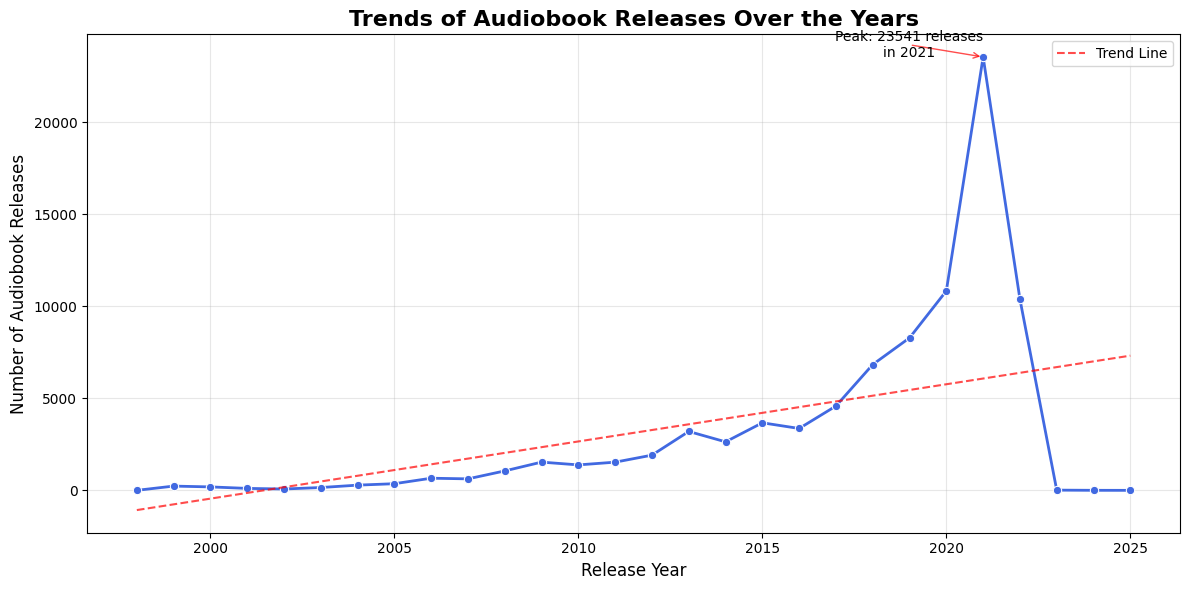


Growth Analysis:
Peak year: 2021 with 23541 releases
Recent 5-year average: 6789.4 releases/year
Early 5-year average: 121.6 releases/year
Market growth: 5483.4% increase in recent years


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we have clean column names (if not already done)
print("Current columns:", data.columns.tolist())

# Verify release_date column exists and is properly formatted
if 'release_date' in data.columns:
    print(f"Release date column type: {data['release_date'].dtype}")
    print(f"Sample release dates: {data['release_date'].dropna().head().tolist()}")
else:
    print("Warning: release_date column not found")

# Convert release_date to datetime if not already done
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

# Extract year from release_date (if not already done)
data['release_year'] = data['release_date'].dt.year

# Remove rows with invalid dates
initial_count = len(data)
data = data.dropna(subset=['release_year'])
final_count = len(data)
print(f"Removed {initial_count - final_count} rows with invalid dates")

# Group by release_year and count entries
release_trend = data.groupby('release_year').size().reset_index(name='release_count')

print("\nAudiobook Releases by Year:")
print(release_trend.tail(10))  # Show last 10 years

# Calculate growth metrics
total_releases = release_trend['release_count'].sum()
years_span = release_trend['release_year'].max() - release_trend['release_year'].min()
avg_per_year = total_releases / len(release_trend)

print(f"\nRelease Statistics:")
print(f"Total releases tracked: {total_releases}")
print(f"Years covered: {years_span} years ({release_trend['release_year'].min()}-{release_trend['release_year'].max()})")
print(f"Average releases per year: {avg_per_year:.1f}")

# Plotting the trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=release_trend, x='release_year', y='release_count', 
             marker='o', color='royalblue', linewidth=2, markersize=6)

# Add trend line
z = np.polyfit(release_trend['release_year'], release_trend['release_count'], 1)
p = np.poly1d(z)
plt.plot(release_trend['release_year'], p(release_trend['release_year']), 
         "r--", alpha=0.7, label=f'Trend Line')

plt.title('Trends of Audiobook Releases Over the Years', fontsize=16, fontweight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Audiobook Releases', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Highlight peak years
peak_year = release_trend.loc[release_trend['release_count'].idxmax()]
plt.annotate(f'Peak: {peak_year["release_count"]} releases\nin {int(peak_year["release_year"])}',
             xy=(peak_year['release_year'], peak_year['release_count']),
             xytext=(peak_year['release_year']-2, peak_year['release_count']+5),
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=10, ha='center')

plt.tight_layout()
plt.show()

# Release trend insights
recent_5_years = release_trend[release_trend['release_year'] >= release_trend['release_year'].max() - 4]
recent_avg = recent_5_years['release_count'].mean()
early_5_years = release_trend[release_trend['release_year'] <= release_trend['release_year'].min() + 4]
early_avg = early_5_years['release_count'].mean()

print(f"\nGrowth Analysis:")
print(f"Peak year: {int(peak_year['release_year'])} with {peak_year['release_count']} releases")
print(f"Recent 5-year average: {recent_avg:.1f} releases/year")
print(f"Early 5-year average: {early_avg:.1f} releases/year")
if recent_avg > early_avg:
    growth_rate = ((recent_avg - early_avg) / early_avg) * 100
    print(f"Market growth: {growth_rate:.1f}% increase in recent years")